In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse.linalg import LinearOperator, cg, gmres

In [2]:
# smoother
def Jacrelax(nx, ny, u, f, iters=1):
    dx = 1.0 / nx 
    dy = 1.0 / ny
    Ax = 1.0 / dx**2
    Ay = 1.0 / dy**2
    Ap = 1.0 / (2.0*(Ax+Ay))

    # implement Dirichlet BC
    u[ 0,:] = -u[ 1,:]
    u[-1,:] = -u[-2,:]
    u[:, 0] = -u[:, 1]
    u[:,-1] = -u[:,-2]

    for _ in range(iters):
        u[1:nx+1, 1:ny+1] = 0.8 * Ap * (Ax*(u[2:nx+2, 1:ny+1] + u[0:nx, 1:ny+1]) + Ay*(u[1:nx+1, 2:ny+2] + u[1:nx+1, 0:ny]) - f[1:nx+1, 1:ny+1])+0.2*u[1:nx+1, 1:ny+1]

    # Dirichlet BC
    u[ 0,:] = -u[ 1,:]
    u[-1,:] = -u[-2,:]
    u[:, 0] = -u[:, 1]
    u[:,-1] = -u[:,-2]

    res = np.zeros([nx+2, ny+2])
    res[1:nx+1, 1:ny+1] = f[1:nx+1, 1:ny+1] - ((Ax*(u[2:nx+2, 1:ny+1]+u[0:nx, 1:ny+1]) + Ay*(u[1:nx+1, 2:ny+2]+u[1:nx+1, 0:ny]) - 2.0*(Ax+Ay)*u[1:nx+1, 1:ny+1]))

    return u, res

In [3]:
# prolongation
def prolong(nx, ny, v):
    v_f = np.zeros([2*nx+2, 2*ny+2])
    v_f[1:2*nx:2  , 1:2*ny:2  ] = 0.5625*v[1:nx+1, 1:ny+1] + 0.1875*(v[0:nx  , 1:ny+1] + v[1:nx+1, 0:ny]  ) + 0.0625*v[0:nx  , 0:ny  ]
    v_f[2:2*nx+1:2, 1:2*ny:2  ] = 0.5625*v[1:nx+1, 1:ny+1] + 0.1875*(v[2:nx+2, 1:ny+1] + v[1:nx+1, 0:ny]  ) + 0.0625*v[2:nx+2, 0:ny  ]
    v_f[1:2*nx:2  , 2:2*ny+1:2] = 0.5625*v[1:nx+1, 1:ny+1] + 0.1875*(v[0:nx  , 1:ny+1] + v[1:nx+1, 2:ny+2]) + 0.0625*v[0:nx  , 2:ny+2]
    v_f[2:2*nx+1:2, 2:2*ny+1:2] = 0.5625*v[1:nx+1, 1:ny+1] + 0.1875*(v[2:nx+2, 1:ny+1] + v[1:nx+1, 2:ny+2]) + 0.0625*v[2:nx+2, 2:ny+2]

    return v_f

In [4]:
# restriction
def restrict(nx,ny,v):
    v_c = np.zeros([nx+2, ny+2])
    v_c[1:nx+1, 1:ny+1] = 0.25*(v[1:2*nx:2, 1:2*ny:2] + v[1:2*nx:2, 2:2*ny+1:2] + v[2:2*nx+1:2, 1:2*ny:2] + v[2:2*nx+1:2, 2:2*ny+1:2])

    return v_c

In [5]:
def V_cycle(nx,ny,num_levels,u,f,level=1):
    # bottom solve
    if level == num_levels:
        u,res = Jacrelax(nx,ny,u,f,iters=50)
        return u, res

    # Step 1: Relax Au=f on this grid
    u, res = Jacrelax(nx, ny, u, f, iters=1)

    # Step 2: Restrict residual to coarse grid
    res_c = restrict(nx//2, ny//2, res)

    # Step 3:Solve A e_c=res_c on the coarse grid. (Recursively)
    e_c = np.zeros_like(res_c)
    e_c, res_c = V_cycle(nx//2, ny//2, num_levels, e_c, res_c, level+1)

    # Step 4: Interpolate(prolong) e_c to fine grid and add to u
    u += prolong(nx//2, ny//2, e_c)

    # Step 5: Relax Au=f on this grid
    u, res = Jacrelax(nx, ny, u, f, iters=1)

    return u,res

In [6]:
# analytical solution
def Uann(x,y):
    return (x**3-x)*(y**3-y)

# righthand-side corresponding to above
def source(x,y):
    return 6*x*y*(x**2+ y**2 - 2)

In [7]:
#input
max_cycles = 30
nlevels    = 8
NX         = 2*2**(nlevels-1)
NY         = 2*2**(nlevels-1)
tol        = 1e-12      

In [8]:
#the grid has one layer of ghost cellss
uann = np.zeros([NX+2, NY+2])#analytical solution
u    = np.zeros([NX+2, NY+2])#approximation
f    = np.zeros([NX+2, NY+2])#RHS

#calcualte the RHS and exact solution
DX = 1.0 / NX
DY = 1.0 / NY

xc = np.linspace(0.5*DX, 1-0.5*DX,NX)
yc = np.linspace(0.5*DY, 1-0.5*DY,NY)
XX, YY = np.meshgrid(xc, yc, indexing='ij')

uann[1:NX+1, 1:NY+1] = Uann(XX,YY)
f[1:NX+1, 1:NY+1] = source(XX,YY)

In [9]:
print('mgd2d.py solver:')
print('NX:',NX,', NY:',NY,', tol:',tol,'levels: ',nlevels)
v_err_arr = []
v_res_arr = []

#start solving
tb = time.time()

for iter in range(1,max_cycles+1):
    u, res = V_cycle(NX, NY, nlevels, u, f)
    rtol = np.max(np.max(np.abs(res)))

    # stop if converge
    if(rtol<tol):
        break

    error = uann[1:NX+1, 1:NY+1] - u[1:NX+1, 1:NY+1]
    v_res_arr.append(rtol)
    v_err_arr.append(np.max(np.max(np.abs(error))))
    print('  cycle: ', iter, ', L_inf(res.)= ', rtol, ',L_inf(true error): ', np.max(np.max(np.abs(error))))

endtime = time.time()
print('Elapsed time: ',endtime-tb,' seconds')    
    
error = uann[1:NX+1, 1:NY+1] - u[1:NX+1, 1:NY+1]
print('L_inf (true error): ', np.max(np.max(np.abs(error))))

mgd2d.py solver:
NX: 256 , NY: 256 , tol: 1e-12 levels:  8
  cycle:  1 , L_inf(res.)=  0.8916667708581372 ,L_inf(true error):  0.04127204489215065
  cycle:  2 , L_inf(res.)=  0.2578801526397001 ,L_inf(true error):  0.011693155015290835
  cycle:  3 , L_inf(res.)=  0.07375328457419528 ,L_inf(true error):  0.0033446037522990857
  cycle:  4 , L_inf(res.)=  0.020952975246473216 ,L_inf(true error):  0.0009623273688910694
  cycle:  5 , L_inf(res.)=  0.005939857619523536 ,L_inf(true error):  0.00027738760944368
  cycle:  6 , L_inf(res.)=  0.0017479424277553335 ,L_inf(true error):  7.935392425784116e-05
  cycle:  7 , L_inf(res.)=  0.0005350082064978778 ,L_inf(true error):  2.1870065956219875e-05
  cycle:  8 , L_inf(res.)=  0.00016443670028820634 ,L_inf(true error):  5.201571393137483e-06
  cycle:  9 , L_inf(res.)=  5.155106191523373e-05 ,L_inf(true error):  4.373528258576212e-06
  cycle:  10 , L_inf(res.)=  1.6443569620605558e-05 ,L_inf(true error):  4.3820661325226756e-06
  cycle:  11 , L_inf(

[]

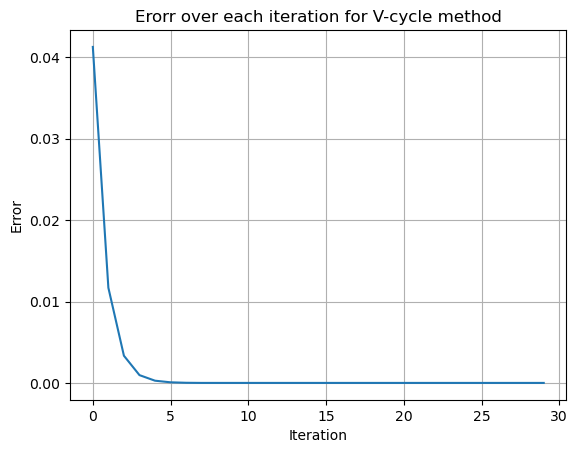

In [87]:
# plot iteration versus error
iterations = np.arange(0, len(v_err_arr))

plt.plot(iterations, v_err_arr)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Erorr over each iteration for V-cycle method")
plt.grid()
plt.plot()

In [12]:
def FMG(nx,ny,num_levels,f,nv=1,level=1):
    #bottom solve
    if level == num_levels:
        u = np.zeros([nx+2, ny+2])  
        u, res = Jacrelax(nx, ny, u, f, iters=50)
        return u,res

    # Step 1: Restrict to a coarse grid
    f_c = restrict(nx//2, ny//2, f)

    # Step 2: Solve the coarse grid problem using FMG
    u_c,_ = FMG(nx//2, ny//2, num_levels, f_c, nv, level+1)

    # Step 3: prolong back to fine grid
    u=prolong(nx//2,ny//2,u_c)

    # step 4: Execute 'nv' V-cycles
    for _ in range(nv):
        u, res = V_cycle(nx, ny, num_levels - level, u, f)

    return u,res

In [13]:
print('mgd2d.py FMG solver:')
print('NX:',NX,', NY:',NY,', levels: ',nlevels)

# start solving
tb = time.time()

u, res = FMG(NX, NY, nlevels, f, nv=1) 

endtime = time.time()
print('Elapsed time: ',endtime-tb,' seconds')    

rtol = np.max(np.max(np.abs(res)))

print(' FMG L_inf(res.)= ',rtol)
error = uann[1:NX+1, 1:NY+1] - u[1:NX+1, 1:NY+1]
print('L_inf (true error): ', np.max(np.max(np.abs(error))))

mgd2d.py FMG solver:
NX: 256 , NY: 256 , levels:  8
Elapsed time:  0.06633591651916504  seconds
 FMG L_inf(res.)=  0.0008938332885009004
L_inf (true error):  4.333766543706359e-06


In [15]:
# preconditioner for Multigrid
def MGVP(nx, ny, num_levels):
    def pc_fn(v):
        u = np.zeros([nx+2, ny+2])
        f = np.zeros([nx+2, ny+2])
        f[1:nx+1, 1:ny+1] = v.reshape([nx, ny])
        
        # perform one V cycle
        u, res = V_cycle(nx, ny, num_levels, u, f)
        return u[1:nx+1, 1:ny+1].reshape(v.shape)
    
    M = LinearOperator((nx*ny,nx*ny), matvec=pc_fn)
    return M

In [16]:
def Laplace(nx, ny):
    def mv(v):
        u = np.zeros([nx+2, ny+2])

        u[1:nx+1, 1:ny+1] = v.reshape([nx, ny])
        dx = 1.0 / nx
        dy = 1.0 / ny
        Ax = 1.0 / dx**2
        Ay = 1.0 / dy**2

        # Boundary Conditions
        u[ 0,:] = -u[ 1,:]
        u[-1,:] = -u[-2,:]
        u[:, 0] = -u[:, 1]
        u[:,-1] = -u[:,-2]

        ut = (Ax*(u[2:nx+2,1:ny+1]+u[0:nx,1:ny+1]) + Ay*(u[1:nx+1,2:ny+2]+u[1:nx+1,0:ny]) - 2.0*(Ax+Ay)*u[1:nx+1,1:ny+1])
        return ut.reshape(v.shape)

    A = LinearOperator((nx*ny, nx*ny), matvec=mv)
    return A

In [18]:
def solve_sparse(solver, A, b, tol=1e-10, maxiter=500, M=None):
    num_iters = 0
    def callback(xk):
        nonlocal num_iters
        num_iters += 1
        
    x, status = solver(A, b, tol=tol, maxiter=maxiter, callback=callback, M=M)
    return x, status, num_iters

In [47]:
def pre_solvers(n_start, n_end):
    A_arr = []
    uex_arr = []
    b_arr = []
    M_arr = []
    NX_arr = []
    NY_arr = []
    
    for i in range(n_start, n_end+1):
        NX = 2*2**(i-1)
        NY = 2*2**(i-1)
        
        A = Laplace(NX, NY)
        # Exact solution and RHS
        uex = np.random.rand(NX*NY,1)
        b = A*uex

        # Multigrid Preconditioner
        M = MGVP(NX,NY,i)
        
        NX_arr.append(NX)
        NY_arr.append(NY)
        A_arr.append(A)
        uex_arr.append(uex)
        b_arr.append(b)
        M_arr.append(M)
        
    return A_arr, uex_arr, b_arr, M_arr, NX_arr, NY_arr

In [48]:
A_arr, uex_arr, b_arr, M_arr, NX_arr, NY_arr = pre_solvers(4, 8)

In [49]:
gmres_iter = []
pre_gmres_iter = []
gmres_err = []
pre_gmres_err = []

In [52]:
# Test for GMRES
for i in range(len(A_arr)):   
    A = A_arr[i]
    b = b_arr[i]
    uex = uex_arr[i]
    M = M_arr[i]
    NX = NX_arr[i]
    NY = NY_arr[i]
    
    # w/o preconditioner
    u, info, iters = solve_sparse(gmres, A, b, tol=1e-10, maxiter=500)
    print('Without preconditioning. status:',info,', Iters: ',iters)
    error = uex.reshape([NX,NY]) - u.reshape([NX,NY])
    print('error :', np.max(np.abs(error)))
    gmres_err.append(np.max(np.abs(error)))
    gmres_iter.append(iters)

    # w/ preconditioner
    u, info, iters = solve_sparse(gmres, A, b, tol=1e-10, maxiter=500, M=M)
    print('With preconditioning. status:', info, ', Iters: ', iters)
    error = uex.reshape([NX,NY]) - u.reshape([NX,NY])
    print('error :',np.max(np.abs(error)))
    pre_gmres_err.append(np.max(np.abs(error)))
    pre_gmres_iter.append(iters)

Without preconditioning. status: 0 , Iters:  94
error : 2.2844254266018993e-09
With preconditioning. status: 0 , Iters:  11
error : 4.0396574974010946e-11
Without preconditioning. status: 0 , Iters:  236
error : 1.0841035180675362e-08
With preconditioning. status: 0 , Iters:  11
error : 8.201284096287509e-11
Without preconditioning. status: 500 , Iters:  500
error : 2.1215250438522126e-05
With preconditioning. status: 0 , Iters:  11
error : 1.3987466740417176e-10
Without preconditioning. status: 500 , Iters:  500
error : 0.05331105399396219
With preconditioning. status: 0 , Iters:  11
error : 2.2867013838023809e-10
Without preconditioning. status: 500 , Iters:  500
error : 0.3955023841688392
With preconditioning. status: 0 , Iters:  13
error : 1.963329498977373e-11


In [53]:
cg_iter = []
pre_cg_iter = []
cg_err = []
pre_cg_err = []

In [54]:
# Test for GMRES
for i in range(len(A_arr)):   
    A = A_arr[i]
    b = b_arr[i]
    uex = uex_arr[i]
    M = M_arr[i]
    NX = NX_arr[i]
    NY = NY_arr[i]

    # Test for CG
    # w/o preconditioner
    u,info,iters = solve_sparse(cg, A, b, tol=1e-10, maxiter=500)
    print('Without preconditioning. status:',info,', Iters: ',iters)
    error = uex.reshape([NX,NY])-u.reshape([NX,NY])
    print('error :',np.max(np.abs(error)))
    cg_err.append(np.max(np.abs(error)))
    cg_iter.append(iters)

    # w/ preconditioner
    u,info,iters = solve_sparse(cg, A, b, tol=1e-10, maxiter=500, M=M)
    print('With preconditioning. status:', info, ', Iters: ', iters)
    error = uex.reshape([NX, NY]) - u.reshape([NX, NY])
    print('error :',np.max(np.abs(error)))
    pre_cg_err.append(np.max(np.abs(error)))
    pre_cg_iter.append(iters)

Without preconditioning. status: 0 , Iters:  55
error : 9.151330040979566e-11
With preconditioning. status: 0 , Iters:  12
error : 9.599909756019542e-11
Without preconditioning. status: 0 , Iters:  108
error : 3.944080062545652e-10
With preconditioning. status: 0 , Iters:  15
error : 2.1079876733054448e-10
Without preconditioning. status: 0 , Iters:  205
error : 1.5166021771761962e-09
With preconditioning. status: 0 , Iters:  15
error : 5.620681697848795e-10
Without preconditioning. status: 0 , Iters:  392
error : 4.6183331603444344e-09
With preconditioning. status: 0 , Iters:  15
error : 9.146972068663217e-10
Without preconditioning. status: 500 , Iters:  500
error : 2.438946466069153e-05
With preconditioning. status: 0 , Iters:  17
error : 1.150750772449527e-09


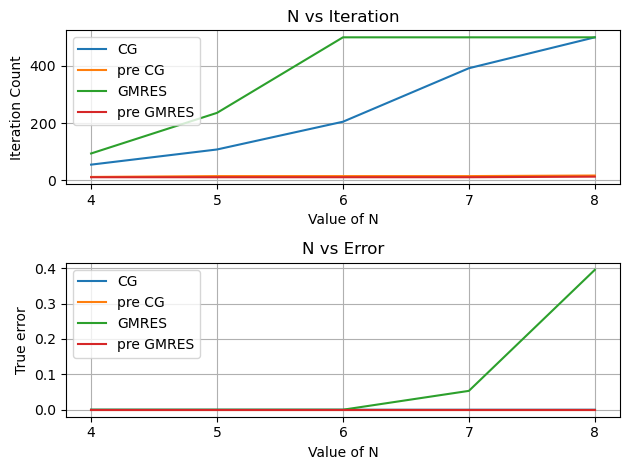

In [55]:
from matplotlib.ticker import MaxNLocator
num = np.arange(4, 9)

fig, (ax1, ax2) = plt.subplots(2,1)

# Plotting the error vs iteration chart
ax1.plot(num, cg_iter, label='CG')
ax1.plot(num, pre_cg_iter, label='pre CG')
ax1.plot(num, gmres_iter, label='GMRES')
ax1.plot(num, pre_gmres_iter, label='pre GMRES')

# Adding labels and title
ax1.set_title('N vs Iteration')
ax1.set_xlabel('Value of N')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_ylabel('Iteration Count')

ax1.grid(True)
ax1.legend()

# Plotting the error vs iteration chart
ax2.plot(num, cg_err, label='CG')
ax2.plot(num, pre_cg_err, label='pre CG')
ax2.plot(num, gmres_err, label='GMRES')
ax2.plot(num, pre_gmres_err, label='pre GMRES')

# Adding labels and title
ax2.set_title('N vs Error')
ax2.set_xlabel('Value of N')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_ylabel('True error')

ax2.grid(True)
ax2.legend()

fig.tight_layout()

# Display the plot
plt.show()

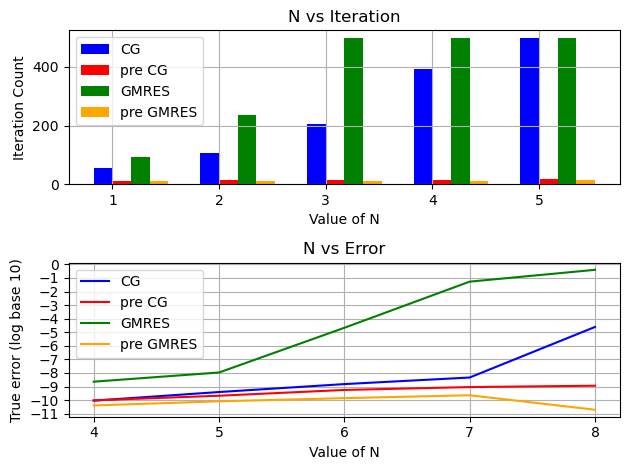

<Figure size 1600x1600 with 0 Axes>

In [85]:
fig, (ax1, ax2) = plt.subplots(2, 1)

bar_width = 0.35

for i, n in enumerate(num):
    x_position = i * 2
    ax1.bar(x_position, cg_iter[i], bar_width, color='blue')
    ax1.bar(x_position+bar_width, pre_cg_iter[i], bar_width, color='red')
    ax1.bar(x_position+2*bar_width, gmres_iter[i], bar_width, color='green')
    ax1.bar(x_position+3*bar_width, pre_gmres_iter[i], bar_width, color='orange')
    
# Set labels and title
ax1.set_title('N vs Iteration')
ax1.set_xlabel('Value of N')
ax1.set_ylabel('Iteration Count')

# Set x-axis ticks and labels
ax1.set_xticks([i * 2 + bar_width / 2 for i in range(len(n_values))])
ax1.set_xticklabels(n_values)

# Plotting the error vs iteration chart
ax2.plot(num, np.log10(cg_err), label='CG', color='blue')
ax2.plot(num, np.log10(pre_cg_err), label='pre CG', color='red')
ax2.plot(num, np.log10(gmres_err), label='GMRES', color='green')
ax2.plot(num, np.log10(pre_gmres_err), label='pre GMRES', color='orange')

# Adding labels and title
ax2.set_title('N vs Error')
ax2.set_xlabel('Value of N')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_yticks(np.arange(-11, 1))
ax2.set_ylabel('True error (log base 10)')

ax1.legend(["CG", "pre CG", "GMRES", "pre GMRES"])
ax1.grid(True)
ax2.legend(["CG", "pre CG", "GMRES", "pre GMRES"])
ax2.grid(True)

fig.tight_layout()
plt.figure(figsize=(16, 16)) 
plt.show()